# Lagrangians

> The behavior of associative memories is captured in the **Lagrangian** of the neurons

We begin with the lagrangian, the fundamental unit of any neuron layer.

In [ ]:
#| default_exp lagrangians

In [ ]:
#| export 
import jax.numpy as jnp
import jax
import numpy as np
from fastcore.test import *
import functools as ft

In [ ]:
#| hide
from nbdev.showdoc import *
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')


## Functional interface

The Lagrangian functions are central to understanding the energy that neuron layers provide to an associative memory, and they can be thought of as the integrand of common activation functions (e.g., `relu`s and `softmax`es. All lagrangians are functions of the form:

$$\mathcal{L}(x;\ldots) \mapsto \mathbb{R}$$

where $x$ can be a tensor of arbitrary shape and $\mathcal{L}$ can be optionally parameterized (e.g., the `LayerNorm`'s learnable bias and scale). It is important that our Lagrangians be convex and differentiable.

We want to rely on JAX's autograd to automatically differentiate our Lagrangians into activation functions. For certain Lagrangians, the naively autodiff-ed function of the defined Lagrangian is numerically unstable (e.g., `lagr_sigmoid(x).sum()` and `lagr_tanh(x).sum()`). In these cases, we follow JAX's [documentation guidelines](https://jax.readthedocs.io/en/latest/notebooks/Custom_derivative_rules_for_Python_code.html) to define `custom_jvp`s to fix this behavior.

In [ ]:
#| export
def lagr_identity(x): 
    """The Lagrangian whose activation function is simply the identity."""
    return 1 / 2 * jnp.power(x, 2)

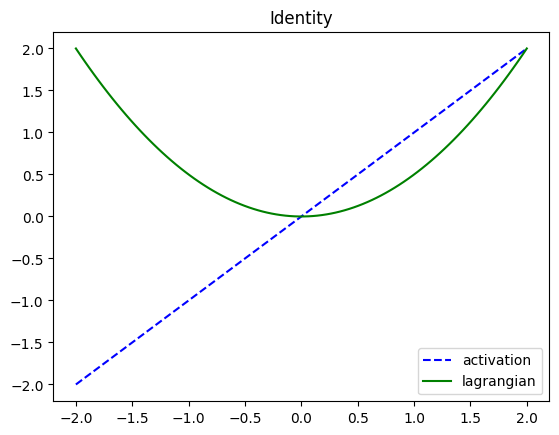

In [ ]:
#| echo: false
x = np.linspace(-2,2,100); ff = lagr_identity
llagr = lambda x: ff(x).sum()
y = jax.grad(llagr)(x)
y2 = ff(x)
fig, ax = plt.subplots(1)
ax.plot(x,y, 'b--', x,y2,'g-')
ax.set_title("Identity")
ax.legend(["activation", "lagrangian"])
plt.show(fig)

In [ ]:
#| export
def lagr_repu(x, 
              n): # Degree of the polynomial in the power unit
    """Rectified Power Unit of degree `n`"""
    return 1 / n * jnp.power(jnp.maximum(x, 0), n)

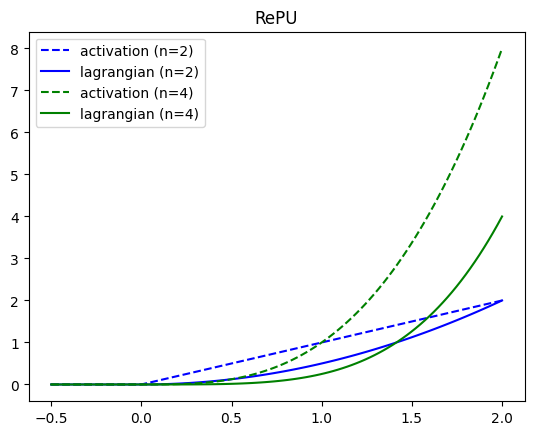

In [ ]:
#| echo: false
x = np.linspace(-0.5,2,100)
ns = [2,4]
fig, ax = plt.subplots(1)
colors = 'bgr'

legend = []
for i, n in enumerate(ns):
    ff = ft.partial(lagr_repu, n=n)
    llagr = lambda x: ff(x).sum()
    act = jax.grad(llagr)(x)
    lag = ff(x)
    # ax.plot(x,act, 'b-', x,lag,'g--')
    c = colors[i]
    legend += [f"activation (n={n})", f"lagrangian (n={n})"]
    ax.plot(x,act,f"{c}--", x,lag,f"{c}-")
    ax.set_title("RePU")

ax.legend(legend)
plt.show(fig)

$$\frac{1}{n} \max(x,0)^n$$

In [ ]:
#| export
def lagr_relu(x):
    """Rectified Linear Unit. Same as repu of degree 2"""
    return lagr_repu(x, 2)

$$\frac{1}{2} \max(x,0)^2$$

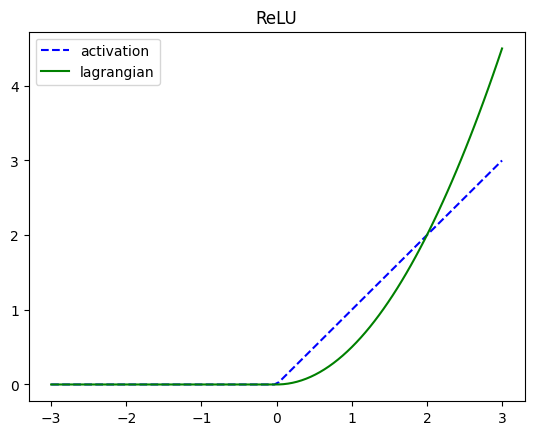

In [ ]:
#| echo: false
x = np.linspace(-3,3,100); ff = lagr_relu
llagr = lambda x: ff(x).sum()
y = jax.grad(llagr)(x)
y2 = ff(x)
fig, ax = plt.subplots(1)
ax.plot(x,y, 'b--', x,y2,'g-')
ax.set_title("ReLU")
ax.legend(["activation", "lagrangian"])
plt.show(fig)

In [ ]:
#| export
def lagr_softmax(x,
                 beta:float=1.0, # Inverse temperature
                 axis:int=-1): # Dimension over which to apply logsumexp
    """The lagrangian of the softmax -- the logsumexp"""
    return (1/beta * jax.nn.logsumexp(beta * x, axis=axis, keepdims=True))

$$\frac{1}{\beta} \log \sum\limits_i \exp(\beta x)$$

We do not plot the `logsumexp` because it has an implicit summation

In [ ]:
#| export
def lagr_exp(x, 
             beta:float=1.0): # Inverse temperature
    """Exponential activation function, as in [Demicirgil et al.](https://arxiv.org/abs/1702.01929). Operates elementwise"""
    return 1 / beta * jnp.exp(beta * x)

$$ \frac{1}{\beta} \exp(\beta x)$$

1.2130613
0.36787945
0.14875345


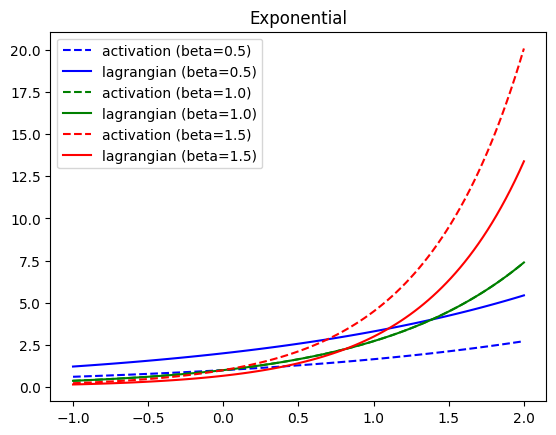

In [ ]:
#| echo: false
x = np.linspace(-1,2,100)
betas = [0.5,1.,1.5]
# betas = [0.5]
fig, ax = plt.subplots(1)
colors = 'bgr'

legend = []
for i, b in enumerate(betas):
    ff = ft.partial(lagr_exp, beta=b)
    llagr = lambda x: ff(x).sum()
    act = jax.grad(llagr)(x)
    lag = ff(x)
    c = colors[i]
    legend += [f"activation (beta={b})", f"lagrangian (beta={b})"]
    ax.plot(x,act,f"{c}--", x,lag,f"{c}-")
    ax.set_title("Exponential")
    print(lag.min())

ax.legend(legend)
plt.show(fig)

In [ ]:
#|export
def lagr_rexp(x, 
             beta:float=1.0): # Inverse temperature
    """Rectified exponential activation function"""
    xclipped = jnp.maximum(x, 0)
    return (1 / beta * jnp.exp(beta * xclipped)-xclipped)

$$\frac{1}{\beta} \exp(\beta \bar{x}) - \bar{x} \ \ \ \ \text{where} \ \ \bar{x} = \max(x,0)$$

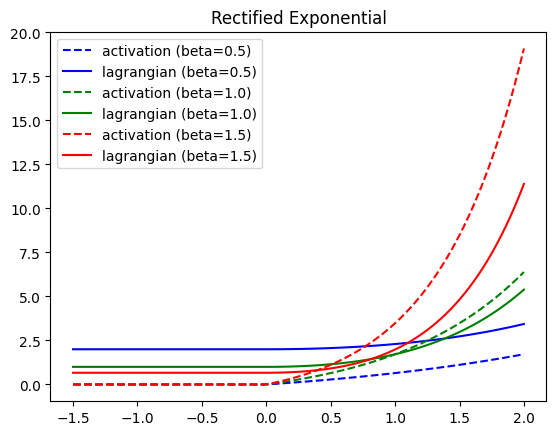

In [ ]:
#| echo: false
x = np.linspace(-1.5,2,100)
betas = [0.5,1.,1.5]
fig, ax = plt.subplots(1)
colors = 'bgr'

legend = []
for i, b in enumerate(betas):
    ff = ft.partial(lagr_rexp, beta=b)
    llagr = lambda x: ff(x).sum()
    act = jax.grad(llagr)(x)
    lag = ff(x)
    # ax.plot(x,act, 'b-', x,lag,'g--')
    c = colors[i]
    legend += [f"activation (beta={b})", f"lagrangian (beta={b})"]
    ax.plot(x,act,f"{c}--", x,lag,f"{c}-")
    ax.set_title("Rectified Exponential")

ax.legend(legend)
plt.show(fig)

The lagrangian of the `tanh` and the `sigmoid` are a bit more numerically unstable. We will need to define custom gradients for them. We show how this is done for the `tanh` case to forward to gradient compute to the optimized `jnp.tanh` function:

In [ ]:
#| exports
@jax.custom_jvp
def _lagr_tanh(x, beta=1.0):
    return 1 / beta * jnp.log(jnp.cosh(beta * x))

@_lagr_tanh.defjvp
def _lagr_tanh_defjvp(primals, tangents):
    x, beta = primals
    x_dot, beta_dot = tangents
    primal_out = _lagr_tanh(x, beta)
    tangent_out = jnp.tanh(beta * x) * x_dot
    return primal_out, tangent_out

def lagr_tanh(x, 
              beta=1.0): # Inverse temperature
    """Lagrangian of the tanh activation function"""
    return _lagr_tanh(x, beta)

In [ ]:
#|hide
x = np.random.randn(4,20);beta=0.2; scale=1.3
llagr = lambda x: lagr_tanh(x, beta=beta).sum()
test_eq(jax.nn.tanh(beta*x), jax.grad(llagr)(x))

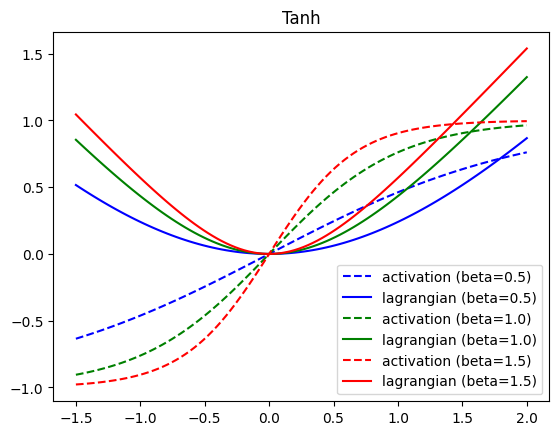

In [ ]:
#| echo: false
x = np.linspace(-1.5,2,100)
betas = [0.5,1.,1.5]
fig, ax = plt.subplots(1)
colors = 'bgr'

legend = []
for i, b in enumerate(betas):
    ff = ft.partial(lagr_tanh, beta=b)
    llagr = lambda x: ff(x).sum()
    act = jax.grad(llagr)(x)
    lag = ff(x)
    # ax.plot(x,act, 'b-', x,lag,'g--')
    c = colors[i]
    legend += [f"activation (beta={b})", f"lagrangian (beta={b})"]
    ax.plot(x,act,f"{c}--", x,lag,f"{c}-")
    ax.set_title("Tanh")

ax.legend(legend)
plt.show(fig)

We define a similar custom JVP for the sigmoid, but its interface is simple.

In [ ]:
#| export
@jax.custom_jvp
def _lagr_sigmoid(x, 
                  beta=1.0, # Inverse temperature
                  scale=1.0): # Amount to stretch the range of the sigmoid's lagrangian
    """The lagrangian of a sigmoid that we can define custom JVPs of"""
    return scale / beta * jnp.log(jnp.exp(beta * x) + 1)

def _tempered_sigmoid(x, 
                     beta=1.0, # Inverse temperature
                     scale=1.0): # Amount to stretch the range of the sigmoid
    """The basic sigmoid, but with a scaling factor"""
    return scale / (1 + jnp.exp(-beta * x))

@_lagr_sigmoid.defjvp
def _lagr_sigmoid_jvp(primals, tangents):
    x, beta, scale = primals
    x_dot, beta_dot, scale_dot = tangents
    primal_out = _lagr_sigmoid(x, beta, scale)
    tangent_out = _tempered_sigmoid(x, beta=beta, scale=scale) * x_dot # Manually defined sigmoid
    return primal_out, tangent_out

def lagr_sigmoid(x, 
                 beta=1.0, # Inverse temperature
                 scale=1.0): # Amount to stretch the range of the sigmoid's lagrangian
    """The lagrangian of the sigmoid activation function"""
    return _lagr_sigmoid(x, beta=beta, scale=scale)

In [ ]:
#|hide
x = np.random.randn(4,20);beta=0.2; scale=1.3
llagr = lambda x: lagr_sigmoid(x, beta=beta, scale=scale).sum()
test_eq(_tempered_sigmoid(x, beta=beta, scale=scale), jax.grad(llagr)(x))

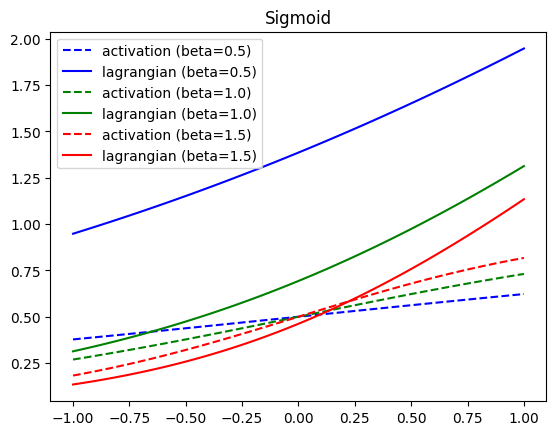

In [ ]:
#| echo: false
x = np.linspace(-1,1,100)
betas = [0.5,1.,1.5]
fig, ax = plt.subplots(1)
colors = 'bgr'

legend = []
for i, b in enumerate(betas):
    ff = ft.partial(lagr_sigmoid, beta=b)
    llagr = lambda x: ff(x).sum()
    act = jax.grad(llagr)(x)
    lag = ff(x)
    # ax.plot(x,act, 'b-', x,lag,'g--')
    c = colors[i]
    legend += [f"activation (beta={b})", f"lagrangian (beta={b})"]
    ax.plot(x,act,f"{c}--", x,lag,f"{c}-")
    ax.set_title("Sigmoid")

ax.legend(legend)
plt.show(fig)

## Parameterized Lagrangians

It is beneficial to consider lagrangians as modules with their own learnable parameters.

In [ ]:
#| export
import treex as tx
from dataclasses import dataclass
from typing import *

In [ ]:
#| export
class LIdentity(tx.Module):
    """Reduced Lagrangian whose activation function is the identity function"""
    def __init__(self): pass
    def __call__(self, x):
        return lagr_identity(x).sum()

class LRepu(tx.Module):
    """Reduced Lagrangian whose activation function is the rectified polynomial unit of specified degree `n`"""
    n: float = 2
    
    # Need a default for `n` to work with layer creation
    def __init__(self,
                 n=2.): # The degree of the RePU. By default, set to the ReLU configuration
        self.n = n

    def __call__(self, x):
        return lagr_repu(x, self.n).sum()
    
class LRelu(tx.Module):
    """Reduced Lagrangian whose activation function is the rectified linear unit"""
    def __init__(self): pass
    def __call__(self, x):
        return lagr_relu(x).sum()
    
class LSigmoid(tx.Module):
    """Reduced Lagrangian whose activation function is the sigmoid
    
    Parameterized by (beta)
    """
    beta: Union[float, jnp.ndarray] = tx.Parameter.node(default=1.0)
    scale: float = tx.Parameter.node(default=1.0)
    min_beta: float = 1e-6
    
    def __init__(self, 
                 beta=1., # Inverse temperature
                 scale=1., # Amount to stretch the sigmoid.
                 min_beta=1e-6): # Minimal accepted value of beta. For energy dynamics, it is important that beta be positive.
        self.beta = beta
        self.scale = scale
        self.min_beta = min_beta

    def __call__(self, x):
        return lagr_simoid(x, beta=jnp.clip(self.beta, self.min_beta), scale=self.scale).sum()
    
class LSoftmax(tx.Module):
    """Reduced Lagrangian whose activation function is the softmax
    
    Parameterized by (beta)
    """
    beta: Union[float, jnp.ndarray] = tx.Parameter.node(default=1.0)
    axis: int = -1
    min_beta: float = 1e-6

    def __init__(self, 
         beta=1., # Inverse temperature
         axis=-1, # Axis over which to apply the softmax
         min_beta=1e-6): # Minimal accepted value of beta. For energy dynamics, it is important that beta be positive.
        self.beta = beta
        self.axis = axis
        self.min_beta = min_beta

    def __call__(self, x):
        return lagr_softmax(x, beta=jnp.clip(self.beta, self.min_beta), axis=self.axis).sum()
    

class LExp(tx.Module):
    """Reduced Lagrangian whose activation function is the exponential function
    
    Parameterized by (beta)
    """
    beta: Union[float, jnp.ndarray] = tx.Parameter.node(default=1.0)
    min_beta: float = 1e-6

    def __init__(self, 
                 beta=1., # Inverse temperature, for the sharpness of the exponent
                 min_beta=1e-6): # Minimal accepted value of beta. For energy dynamics, it is important that beta be positive.
        self.beta = beta
        self.min_beta = min_beta
        
    def __call__(self, x):
        return lagr_exp(x, beta=jnp.clip(self.beta, self.min_beta)).sum()
    
class LRexp(tx.Module):
    """Reduced Lagrangian whose activation function is the rectified exponential function
    
    Parameterized by (beta)
    """
    beta: Union[float, jnp.ndarray] = tx.Parameter.node(default=1.0)
    min_beta: float = 1e-6

    def __init__(self, 
                 beta=1., # Inverse temperature, for the sharpness of the exponent
                 min_beta=1e-6): # Minimal accepted value of beta. For energy dynamics, it is important that beta be positive.
        self.beta = beta
        self.min_beta = min_beta
        
    def __call__(self, x):
        return lagr_rexp(x, beta=jnp.clip(self.beta, self.min_beta)).sum()
    
    
class LTanh(tx.Module):
    """Reduced Lagrangian whose activation function is the tanh
    
    Parameterized by (beta)
    """
    beta: Union[float, jnp.ndarray] = tx.Parameter.node(default=1.0)
    min_beta: float = 1e-6

    def __init__(self, 
                 beta=1., # Inverse temperature, for the sharpness of the exponent
                 min_beta=1e-6): # Minimal accepted value of beta. For energy dynamics, it is important that beta be positive.
        self.beta = beta
        self.min_beta = min_beta

    def __call__(self, x):
        return lagr_tanh(x, beta=jnp.clip(self.beta,self.min_beta)).sum()

The modules can be initialized and used as follows:

In [ ]:
lag = LRepu(n=4)
x = jax.random.normal(jax.random.PRNGKey(1), (7,))
lag(x)

DeviceArray(1.6991202, dtype=float32)

To apply the lagrangian to a batch of samples, we should take advantage of `jax.vmap`

In [ ]:
lag = jax.vmap(LRepu(n=4)); batch_size = 4
x = jax.random.normal(jax.random.PRNGKey(1), (batch_size,7))
lag(x)

DeviceArray([0.79066116, 0.634871  , 0.13261071, 3.3233747 ], dtype=float32)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()